In [1]:
import pandas as pd

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC

from pprint import pprint

import re
import numpy as np

import helper_functions

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
with open("./data/IN/valid_proteins.fasta") as handle:
    valid_cafa_seq = list( SeqIO.parse(handle, 'fasta') )
    valid_cafa_ac = {seq.id for seq in valid_cafa_seq}

In [3]:
with open("./data/IN/uniprot/uniprot_sprot.dat") as handle:
    swiss_seq = [ rec for rec in SeqIO.parse(handle, "swiss") if
                    any(ac in valid_cafa_ac for ac in rec.annotations["accessions"]) ]


In [4]:
len(swiss_seq), len(valid_cafa_ac)

(66584, 66599)

In [5]:
missing_ac = valid_cafa_ac - {rec.id for rec in swiss_seq}
acc_mapping = pd.DataFrame( [ (rec.id, ac) for rec in swiss_seq for ac in rec.annotations['accessions']
                                                                       if ac in missing_ac] 
                            , columns=['id', 'ac'])
print(len(set(acc_mapping.id)))
acc_mapping.head() 

69


,id,ac
0,C0HK79,Q9D365
1,C0HK80,Q9D365
2,P0DP23,P62158
3,P0DP26,P62204
4,P0DP29,P62161


In [11]:
invalid_mid = set(acc_mapping.join(acc_mapping.groupby('ac').count(), on='ac', rsuffix='r').query("idr>1").id)
fixed_mapping = acc_mapping[ [mid not in invalid_mid for mid in acc_mapping.id]]

In [12]:
import pygraphviz as pgv
from IPython import display

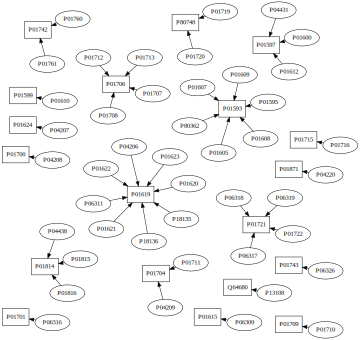

In [13]:
G = pgv.AGraph(directed=True, size=5, strict=True)
for _, pac, sac in fixed_mapping.itertuples():
    G.add_node(pac, shape='rectangle')
    G.add_edge(sac, pac, len=1)
    
G.layout(prog='fdp')
display.display_svg(G.draw(format='svg'), raw=True)

In [388]:
valid_swiss_seq = list(filter(lambda x: x.id not in invalid_mid, swiss_seq))
len(valid_swiss_seq)

66534

In [410]:
for ac in set(fixed_mapping.id):
    print(ac, "Exists" if ac in valid_cafa_ac else "\\" )

Q64680 Exists
P01701 Exists
P01709 Exists
P01871 Exists
P80748 Exists
P01619 \
P01814 \
P01700 Exists
P01593 Exists
P01706 Exists
P01599 Exists
P01624 Exists
P01597 \
P01721 Exists
P01704 Exists
P01742 Exists
P01615 \
P01743 Exists
P01715 Exists


In [253]:
swiss_valid_ac = valid_cafa_ac.intersection({rec.id for rec in swiss_seq})
len(swiss_valid_ac)

66530

# Eksport AC/GO nad AC/KW

## keywords parser

In [102]:
import mmap

class Keyword():
    def __init__(self, kw): self.__dict__.update(kw)
    def get_name(self):     return self.ID if 'ID' in self.__dict__ else self.IC
    def get_category(self): return self.CA if 'ID' in self.__dict__ else self.IC
    def is_category(self):  return 'IC' in self.__dict__
    def is_keyword(self):   return 'ID' in self.__dict__
    def __repr__(self): return repr(self.__dict__)
    def __str__(self): return repr(self)
    
def parse_keywlist(path):

    id_re = re.compile(rb'(ID|IC) \s+ ([^.]+) .\s+  AC \s+ (KW-\d{4}) \s+', re.X)
    multiline_re = re.compile(rb'//\s+|(\w\w)\s+([^\.]+)\.\s+', re.S)
    kw_split_re = re.compile('\s*[;:]\s*')

    kw_names = {}
    kw_acs = {}

    with open(path, 'rb+') as file:
        mem = mmap.mmap(file.fileno(), 0)
        pos = re.search(b'^ID', mem, re.M).start()

        while True:
            m = id_re.match(mem, pos)
            if not m:
                break

            id_type, id_value, AC = [x.decode() for x in m.groups()]
            rec = Keyword( {id_type:id_value, 'AC': AC, 'GO':[], 'HI':set(), 'WW':[]} )


            for m in multiline_re.finditer(mem, m.end()):
                k, v= m.groups()

                if not k: 
                    pos = m.end() # got '//' update pos for the next kw
                    break

                k = k.decode()
                v = v.decode()

                if k=='DE':
                    rec.DE = v.replace('\nDE   ', ' ')
                elif k=='SY':
                    rec.SY = [w.strip() for w in v.replace('\nSY   ', '').split(';') ]
                elif(k=='GO'):
                    rec.GO.append( v[:10] )
                elif(k=='HI'):
                    rec.HI.add( kw_split_re.split(v)[-2] ) # -1 is ID, -2 is predecessor
                elif(k=='CA'):
                    rec.CA = v
                elif(k=='WW'):
                    rec.WW.append(v)

            kw_acs[rec.AC] = rec
            kw_names[ rec.get_name() ] = rec

            
        #pprint(rec)
        #break # debug
    return kw_names, kw_acs

In [103]:
kw_names, kw_acs = parse_keywlist('data/IN/keywlist.txt')

In [118]:
kw2prot_MF = []
for rec in swiss_seq:
    if 'keywords' not in rec.annotations:
        continue
    for kw_name in rec.annotations['keywords']:
        kw = kw_names[kw_name]
        if 'CA' in kw.__dict__ and kw.CA == "Molecular function":
            kw2prot_MF.append( (rec.id, kw.AC) )

                
kw2prot_MF = pd.DataFrame(kw2prot_MF, columns=['prot_ac', 'kw_ac'])
kw2prot_MF.set_index('kw_ac', inplace=True)
kw2prot_MF.head()

,prot_ac
kw_ac,
KW-0217,P29310
KW-0456,Q9S9U6
KW-0456,Q06402
KW-0456,Q43309
KW-0456,Q37001


In [128]:
from GO.obo_parser import  *
import json

In [127]:
with open("data/IN/go.json", "r") as obo_file:
    terms = json.load(obo_file)

In [129]:
for rec in swiss_seq:
    print(rec.dbxrefs)
    
    break

['EMBL:AF162273', 'OrthoDB:VOG090002NC', 'Proteomes:UP000006624', 'GO:GO:0030430', 'GO:GO:0039526']
